In [178]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install lightgbm
%pip install xgboost
%pip install keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from datetime import datetime
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam, SGD, RMSprop

In [2]:
cassava_data = pd.read_csv("cassava_dataset.csv")
weather_data = pd.read_csv("weather data.csv")
cassava_data.describe().T

C:\Users\ZBOOK\AppData\Local\Temp\ipykernel_18720\1650131993.py:1: DtypeWarning: Columns (7,8,26,29,33,39,40,44,52,56,68,72) have mixed types. Specify dtype option on import or set low_memory=False.
  cassava_data = pd.read_csv("cassava_dataset.csv")


,count,mean,std,min,25%,50%,75%,max
year,24637.0,2015.156310,2.304484,1996.0,2013.0000,2015.000,2017.00000,2022.0
plotWidth,21955.0,2.383739,1.696465,1.0,1.0000,1.000,4.00000,16.0
plotLength,21955.0,4.909387,1.727796,2.5,3.5000,5.500,5.50000,20.0
fieldSize,15988.0,0.328239,0.320640,0.0,0.1024,0.215,0.58975,7.2
rep,24637.0,1.989853,6.093928,1.0,1.0000,1.000,2.00000,146.0
...,...,...,...,...,...,...,...,...
stemwt,4.0,6.425000,4.350000,0.8,4.4000,6.950,8.97500,11.0
storgshp,19909.0,2.140841,0.497991,1.0,2.0000,2.000,2.00000,7.0
rtsz,19555.0,4.330095,1.318708,2.0,3.0000,5.000,5.00000,7.0
tyld,15015.0,25.239272,20.601212,0.0,13.8000,22.500,32.60000,1512.5


In [3]:
cassava_data.columns

Index(['year', 'programName', 'trial', 'studyDesign', 'plotWidth',
       'plotLength', 'fieldSize', 'plantingDate', 'harvestDate', 'location',
       'accession', 'plotname', 'rep', 'block_num', 'plot_num', 'row_num',
       'col_num', 'entryType', 'brnhbt', 'brnhlv', 'cad3i', 'cad6i', 'cad9i',
       'cad3s', 'cad6s', 'cad9s', 'cbb3i', 'cbb6i', 'cbb9i', 'cbb3s', 'cbb6s',
       'cbb9s', 'cbsd12i', 'cbsdr12s', 'cgm1', 'cgm2', 'cmbs', 'cmd1i',
       'cmd12i', 'cmd3i', 'cmd6i', 'cmd9i', 'cmd1s', 'cmd12s', 'cmd3s',
       'cmd6s', 'cmd9s', 'dmspg', 'dm', 'dmQ', 'dyld', 'fibre', 'brnht',
       'fyld', 'fshtwt', 'fstortwt', 'hi', 'vigor', 'mkrtwt', 'nmrtwt',
       'pltsk', 'petcol', 'pltarc', 'pltht', 'nohav', 'lodplt', 'rtvr',
       'nklgt', 'rtno', 'rwtair', 'rwtwat', 'rtrot', 'spgrv', 'sprtct9',
       'sprtct1', 'sprtct6', 'sprtct3', 'sprout', 'Starch', 'sg', 'stmcol',
       'stemwt', 'storgshp', 'rtsz', 'tyld', 'yldQ'],
      dtype='object')

In [4]:
## Wrangle weather data

w_df = weather_data.copy()
w_df.columns = [cols.lower() for cols in w_df.columns]
w_df = w_df.drop(columns=["allsky_sfc_sw_dwn","clrsky_sfc_sw_dwn"]).replace(-999.0, np.nan).dropna()

w_df['date'] = w_df[['year', 'mo', 'dy']].astype('str').agg('/'.join, axis=1)
weather_data_ibadan = w_df.drop(columns = ['year','mo','dy'])

In [5]:
## Filter out all the cassava data from Ibadan

cassava_data_ibadan = cassava_data[cassava_data['location'] == "Ibadan"]
cassava_data_ibadan.columns = [cols.lower() for cols in cassava_data_ibadan.columns]
cassava_data_ibadan = cassava_data_ibadan.drop(columns=['plotlength', 'plotwidth', 'dyld','tyld', 'dmspg', 'hi', 'studydesign', 'trial', 'plot_num', 'plotname','block_num','rep','fieldsize', 'programname','col_num','row_num'])
cassava_data_ibadan = cassava_data_ibadan.dropna(subset=["dm","fyld","spgrv","plantingdate","harvestdate"])

cassava_data_ibadan['planting_month'] = pd.to_datetime(cassava_data_ibadan['plantingdate'])
cassava_data_ibadan["planting_date"] = [full_date.strftime('%Y-%m-%d') for full_date in cassava_data_ibadan['planting_month']]

cassava_data_ibadan['harvest_month'] = pd.to_datetime(cassava_data_ibadan['harvestdate'])
cassava_data_ibadan["harvest_date"] = [full_date.strftime('%Y-%m-%d') for full_date in cassava_data_ibadan['harvest_month']]
cassava_data_ibadan = cassava_data_ibadan.drop(columns = ["year","harvest_month",'harvestdate',"planting_month",'plantingdate'])

cassava_data_ibadan = cassava_data_ibadan.reset_index().drop(columns="index")




In [6]:
cassava_data_ibadan.columns

Index(['location', 'accession', 'entrytype', 'brnhbt', 'brnhlv', 'cad3i',
       'cad6i', 'cad9i', 'cad3s', 'cad6s', 'cad9s', 'cbb3i', 'cbb6i', 'cbb9i',
       'cbb3s', 'cbb6s', 'cbb9s', 'cbsd12i', 'cbsdr12s', 'cgm1', 'cgm2',
       'cmbs', 'cmd1i', 'cmd12i', 'cmd3i', 'cmd6i', 'cmd9i', 'cmd1s', 'cmd12s',
       'cmd3s', 'cmd6s', 'cmd9s', 'dm', 'dmq', 'fibre', 'brnht', 'fyld',
       'fshtwt', 'fstortwt', 'vigor', 'mkrtwt', 'nmrtwt', 'pltsk', 'petcol',
       'pltarc', 'pltht', 'nohav', 'lodplt', 'rtvr', 'nklgt', 'rtno', 'rwtair',
       'rwtwat', 'rtrot', 'spgrv', 'sprtct9', 'sprtct1', 'sprtct6', 'sprtct3',
       'sprout', 'starch', 'sg', 'stmcol', 'stemwt', 'storgshp', 'rtsz',
       'yldq', 'planting_date', 'harvest_date'],
      dtype='object')

In [7]:
weather_data_ibadan['date'] = pd.to_datetime(weather_data_ibadan['date'])

planting_dates = list(cassava_data_ibadan["planting_date"])
harvest_dates = list(cassava_data_ibadan["harvest_date"])

agg_data_array = []
days = []

for i in range(0, len(planting_dates)):
    filtered_data = weather_data_ibadan[(weather_data_ibadan["date"] >= planting_dates[i]) & (weather_data_ibadan['date'] <= harvest_dates[i])]
    aggregated_data = filtered_data.mean()
    agg_data_array.append(aggregated_data)
    
    start_date = datetime.strptime(planting_dates[i], '%Y-%m-%d')
    end_date = datetime.strptime(harvest_dates[i], '%Y-%m-%d')
    difference =  end_date - start_date
    number_of_days = difference.days
    days.append(number_of_days)    

cassava_data_ibadan["number_of_days"] = days
agg_weather_data = pd.DataFrame(agg_data_array).drop(columns = "date")

In [8]:
cass_weather_data = pd.concat([cassava_data_ibadan, agg_weather_data], axis=1)
cass_weather_data.head(3)
cass_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4218 entries, 0 to 4217
Data columns (total 75 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          4218 non-null   object 
 1   accession         4218 non-null   object 
 2   entrytype         4218 non-null   object 
 3   brnhbt            0 non-null      float64
 4   brnhlv            100 non-null    float64
 5   cad3i             1 non-null      float64
 6   cad6i             3811 non-null   float64
 7   cad9i             2988 non-null   float64
 8   cad3s             0 non-null      float64
 9   cad6s             3918 non-null   float64
 10  cad9s             3083 non-null   float64
 11  cbb3i             4166 non-null   object 
 12  cbb6i             4054 non-null   float64
 13  cbb9i             4 non-null      float64
 14  cbb3s             4167 non-null   object 
 15  cbb6s             4056 non-null   float64
 16  cbb9s             4 non-null      float64


              fyld
harvest_date      
2012-05-31    14.0
2012-05-31    20.0
2012-05-31    20.0
2012-05-31     6.0
2012-05-31    18.2
...            ...
2023-05-31    22.1
2023-05-22    28.0
2023-05-22    44.4
2023-06-13    22.8
2023-06-13    24.9

[4218 rows x 1 columns]


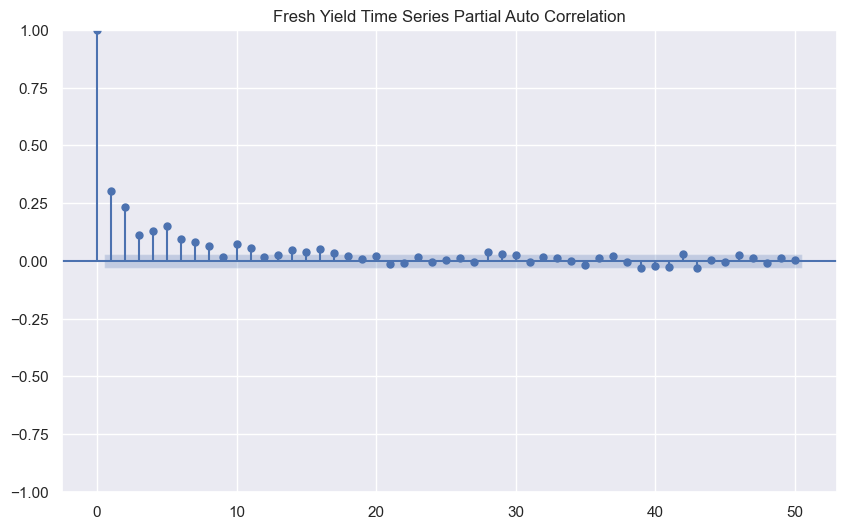

In [264]:
time_series = cass_weather_data[["harvest_date", "fyld"]]
time_series.set_index("harvest_date", inplace=True)
print(time_series)

plt.rc("figure", figsize=(10,6))
plot_pacf(time_series, lags=50, title="Fresh Yield Time Series Partial Auto Correlation")
plt.show()

              fyld
harvest_date      
2012-05-31    14.0
2012-05-31    20.0
2012-05-31    20.0
2012-05-31     6.0
2012-05-31    18.2
...            ...
2023-05-31    22.1
2023-05-22    28.0
2023-05-22    44.4
2023-06-13    22.8
2023-06-13    24.9

[4218 rows x 1 columns]


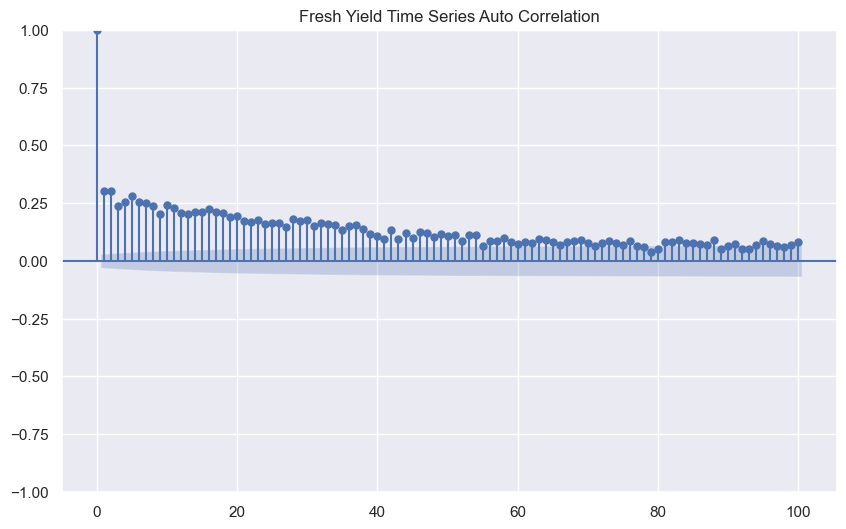

In [278]:
time_series = cass_weather_data[["harvest_date", "fyld"]]
time_series.set_index("harvest_date", inplace=True)
print(time_series)

plt.rc("figure", figsize=(10,6))
plot_acf(time_series, lags=100, title="Fresh Yield Time Series Auto Correlation")
plt.show()


                dm
harvest_date      
2012-05-31    32.5
2012-05-31    39.4
2012-05-31    36.4
2012-05-31    38.4
2012-05-31    33.8
...            ...
2023-05-31    19.3
2023-05-22    25.0
2023-05-22    25.1
2023-06-13    18.5
2023-06-13    17.0

[4218 rows x 1 columns]


<Figure size 1000x600 with 0 Axes>

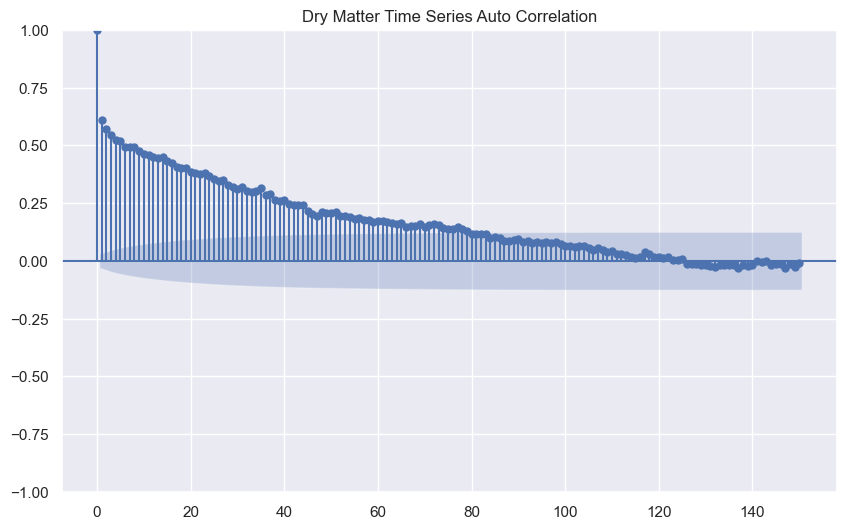

In [280]:
time_series = cass_weather_data[["harvest_date", "dm"]]
time_series.set_index("harvest_date", inplace=True)
print(time_series)

plt.figure(figsize=(10, 6))
plot_acf(time_series, lags=150,title="Dry Matter Time Series Auto Correlation")
plt.show()

                dm
harvest_date      
2012-05-31    32.5
2012-05-31    39.4
2012-05-31    36.4
2012-05-31    38.4
2012-05-31    33.8
...            ...
2023-05-31    19.3
2023-05-22    25.0
2023-05-22    25.1
2023-06-13    18.5
2023-06-13    17.0

[4218 rows x 1 columns]


<Figure size 1000x600 with 0 Axes>

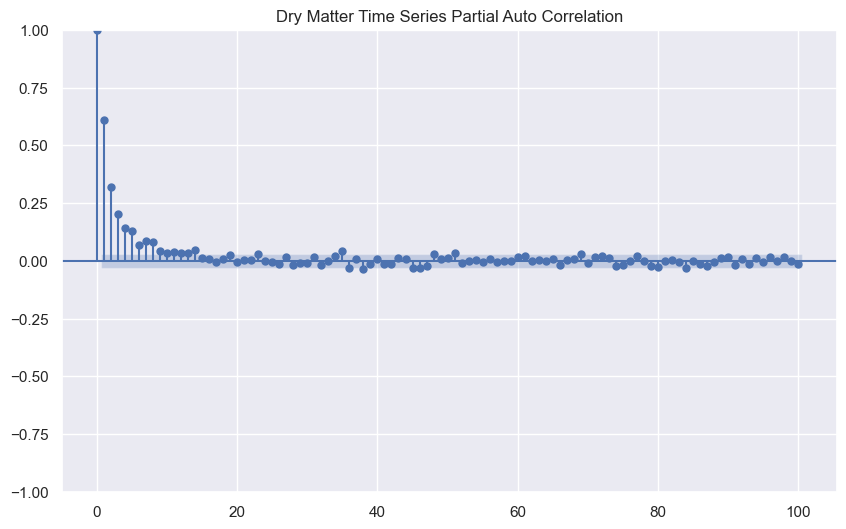

In [281]:
time_series = cass_weather_data[["harvest_date", "dm"]]
time_series.set_index("harvest_date", inplace=True)
print(time_series)

plt.figure(figsize=(10, 6))
plot_pacf(time_series, lags=100,title="Dry Matter Time Series Partial Auto Correlation")
plt.show()


In [11]:

df = cass_weather_data.copy()
df = df.drop(columns = ["planting_date","harvest_date"])
df = df.loc[:, cass_weather_data.isna().mean() < .3]
df = df.dropna(axis=0).reset_index().drop(columns = "index")

label_encoder = LabelEncoder()
df["accession"] = label_encoder.fit_transform(df['accession'])
df["entrytype"] = label_encoder.fit_transform(df['entrytype'])

last_10_columns = df.columns[3:]
desired_datatype = 'float'
df[last_10_columns] = df[last_10_columns].astype(desired_datatype)

df = df[df['fyld'] <= 80]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2443 entries, 0 to 2450
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          2443 non-null   object 
 1   accession         2443 non-null   int32  
 2   entrytype         2443 non-null   int32  
 3   cad6i             2443 non-null   float64
 4   cad9i             2443 non-null   float64
 5   cad6s             2443 non-null   float64
 6   cad9s             2443 non-null   float64
 7   cbb3i             2443 non-null   float64
 8   cbb6i             2443 non-null   float64
 9   cbb3s             2443 non-null   float64
 10  cbb6s             2443 non-null   float64
 11  cmd1i             2443 non-null   float64
 12  cmd3i             2443 non-null   float64
 13  cmd6i             2443 non-null   float64
 14  cmd1s             2443 non-null   float64
 15  cmd3s             2443 non-null   float64
 16  cmd6s             2443 non-null   float64
 17  

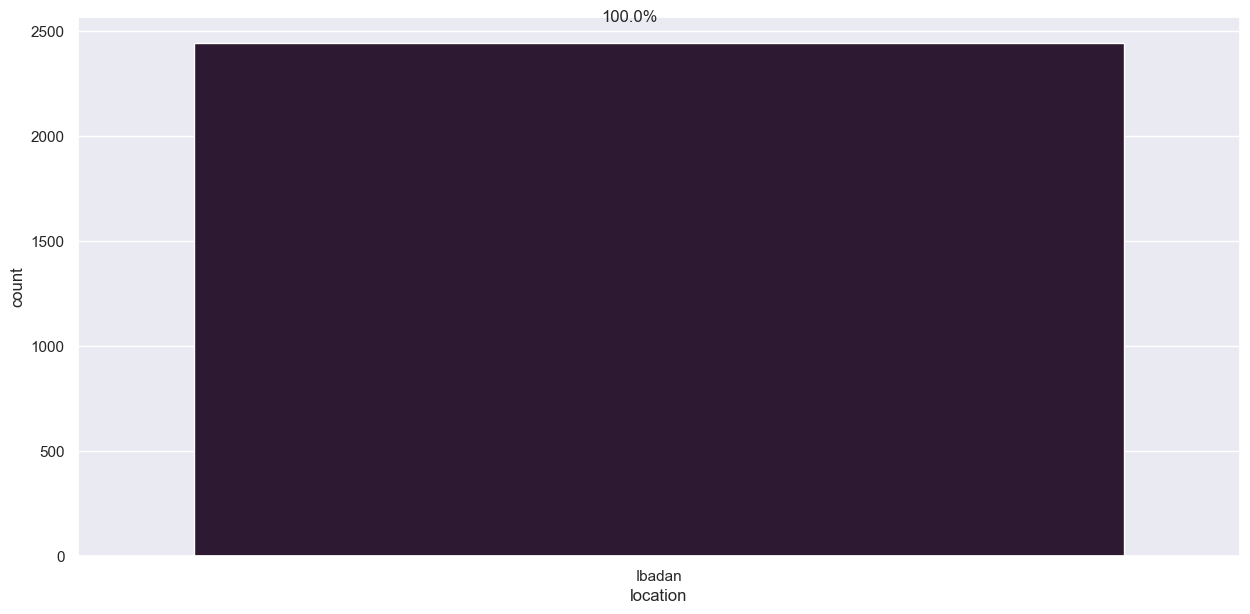

In [12]:
def perc_on_bar(feature, data):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    #Creating a countplot for the feature
    sns.set(rc={'figure.figsize':(15,7)})
    ax=sns.countplot(x=feature, data=data, palette='twilight')

    total = len(feature) # length of the column
    for p in ax.patches:
        # percentage of each class of the category
        percentage = 100 * p.get_height()/total
        percentage_label = f"{percentage:.1f}%"
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height() + 100          # hieght of the plot
        ax.annotate(percentage_label, (x, y), size = 12) # annotate the percantage

    plt.show()
    
perc_on_bar(df.location, df)

In [13]:
df_numeric = df._get_numeric_data()

# df_numeric = df_numeric.groupby("accession").mean()

X = df_numeric.drop(columns = ['fyld','dm'], axis=1)  # Features
y = df_numeric[['fyld','dm']]  # Target variable

# Calculate the correlation matrix
corr_matrix = X.corr()

# Create a mask to ignore self-correlation (diagonal elements)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Filter out highly correlated features
threshold = 0.7  # Define your threshold for correlation
corr_matrix_filtered = corr_matrix.mask(mask).abs()  # Exclude diagonal elements and take absolute values
highly_correlated_features = [column for column in corr_matrix_filtered.columns if any(corr_matrix_filtered[column] > threshold)]
X_selected = X.drop(columns=list(highly_correlated_features))
X_selected = X_selected.drop(columns=["accession", "fstortwt"])
X_selected.columns

Index(['entrytype', 'cad6s', 'cad9s', 'cbb3i', 'cbb3s', 'cbb6s', 'cmd1s',
       'cmd3s', 'cmd6s', 'fshtwt', 'vigor', 'nohav', 'nklgt', 'rtno', 'rwtair',
       'rwtwat', 'rtrot', 'spgrv', 'sprout', 'storgshp', 'rtsz',
       'number_of_days', 'min_temp', 'precipitation', 'surface_pressure',
       'humidity'],
      dtype='object')

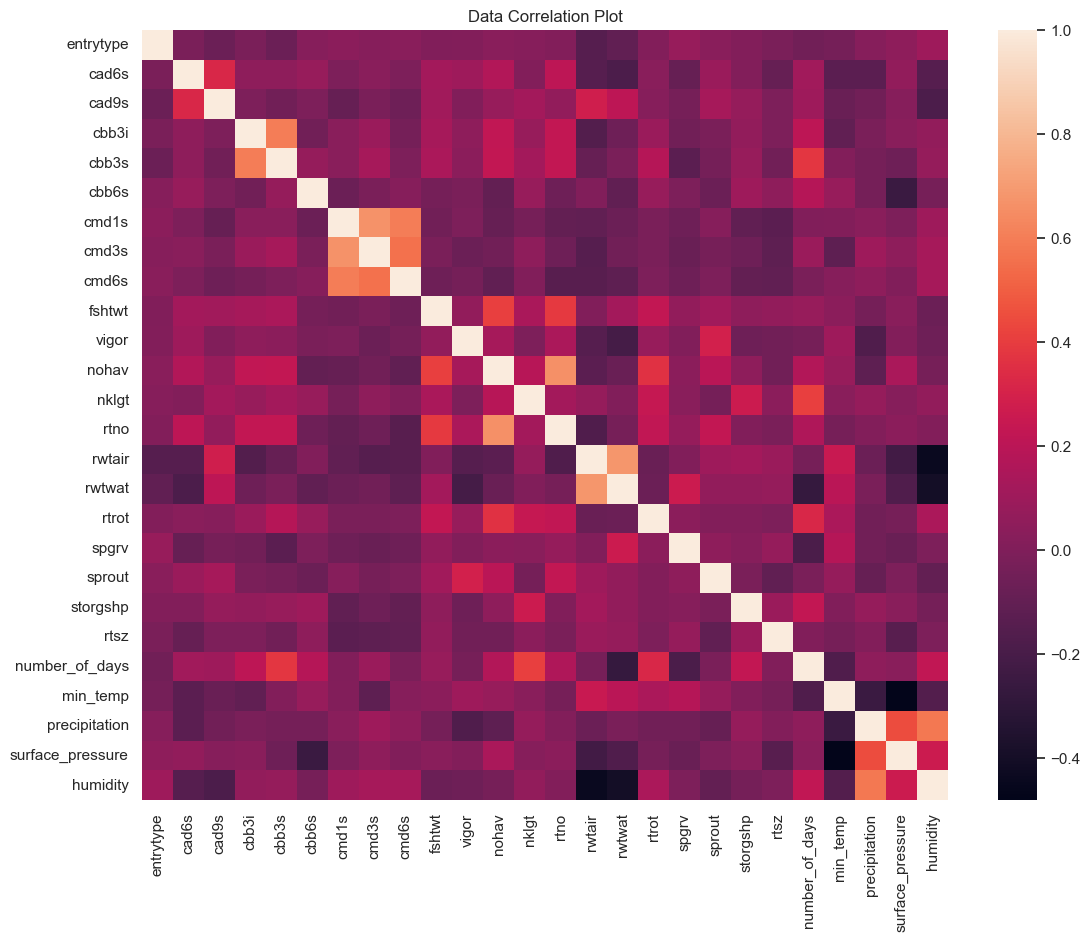

In [263]:
df_corr = round(X_selected.corr(), 2)
plt.figure(figsize=(13,10))
ax = sns.heatmap(df_corr, annot=False)
plt.title("Data Correlation Plot")
plt.show(ax)

In [15]:
features = X_selected.copy()
target = y.copy()
features

,entrytype,cad6s,cad9s,cbb3i,cbb3s,cbb6s,cmd1s,cmd3s,cmd6s,fshtwt,...,rtrot,spgrv,sprout,storgshp,rtsz,number_of_days,min_temp,precipitation,surface_pressure,humidity
0,1,3.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,14.0,...,0.0,1.07,1.0,2.0,5.0,380.0,22.810789,3.670461,100.077171,85.655789
1,1,3.0,2.0,0.3,2.0,2.0,1.0,3.0,1.0,22.4,...,0.0,1.12,1.0,2.0,7.0,380.0,22.810789,3.670461,100.077171,85.655789
2,1,2.0,3.0,0.0,1.0,3.0,1.0,2.0,1.0,16.0,...,1.0,1.11,1.0,2.0,5.0,380.0,22.810789,3.670461,100.077171,85.655789
3,1,2.0,3.0,0.0,1.0,3.0,1.0,1.0,1.0,8.0,...,0.0,1.12,1.0,2.0,3.0,380.0,22.810789,3.670461,100.077171,85.655789
4,1,3.0,2.0,0.0,1.0,2.0,1.0,1.0,1.0,12.0,...,0.0,1.11,1.0,3.0,5.0,380.0,22.810789,3.670461,100.077171,85.655789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,1,1.0,2.0,0.2,2.0,1.0,1.0,1.0,1.0,19.6,...,0.0,1.10,1.0,1.0,3.0,337.0,22.550237,4.259941,100.160947,85.811450
2447,1,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,24.4,...,0.0,1.10,0.9,1.0,3.0,337.0,22.550237,4.259941,100.160947,85.811450
2448,1,2.0,2.0,0.5,2.0,1.0,2.0,1.0,1.0,13.2,...,0.0,1.00,1.0,2.0,3.0,337.0,22.550237,4.259941,100.160947,85.811450
2449,0,2.0,2.0,0.4,3.0,2.0,1.0,1.0,1.0,19.4,...,4.0,1.10,0.9,3.0,5.0,423.0,22.748325,4.681439,100.153750,86.325189


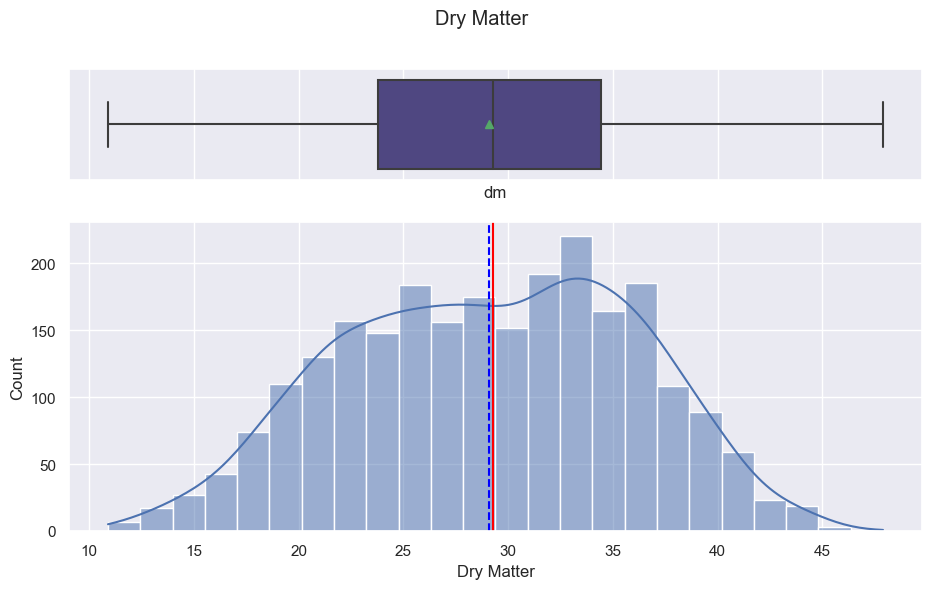

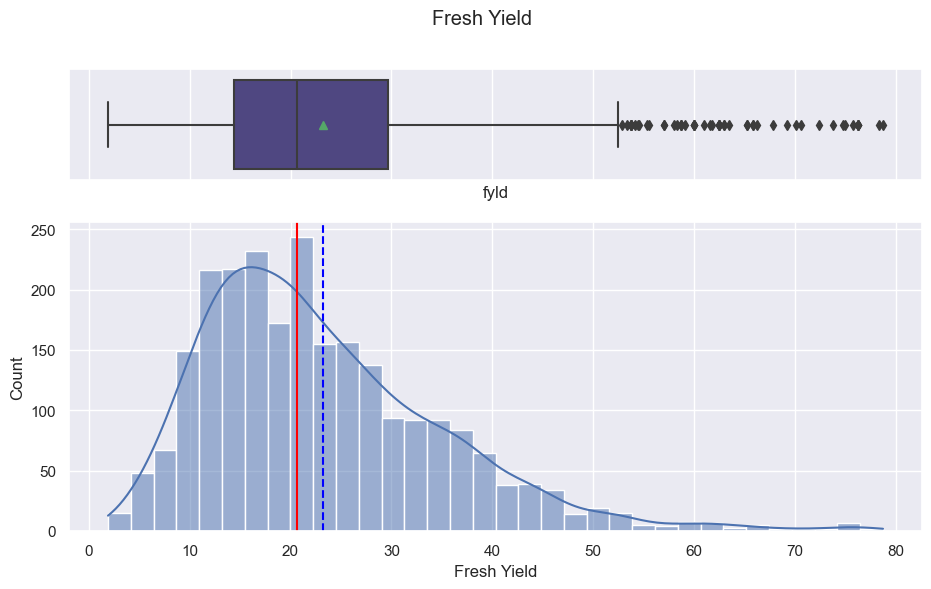

In [117]:
def histogram_boxplot(feature,title, figsize=(11, 6), bins=None):
    """
    Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of f  ig (default (15,10))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .70)},
                                           figsize = figsize
                                           ) # creating the 2 subplots
    
    f2.suptitle(title)

    sns.boxplot(x = feature, ax=ax_box2, showmeans=True, color='darkslateblue') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(feature, kde=True, ax=ax_hist2, bins=bins) if bins else sns.histplot(feature, kde=True, ax=ax_hist2, edgecolor = "white") # For histogram
    plt.xlabel(title)
    ax_hist2.axvline(np.mean(feature), color='blue', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='red', linestyle='-') # Add median to the histogram
    
    
histogram_boxplot(target["dm"], title="Dry Matter")
histogram_boxplot(target["fyld"], title="Fresh Yield")

In [17]:
# Implementing L1 Regularization for feature selection
def prepare_data(target_column: int):
    global features
    global target
    features_names = features.columns
    target_names = target.columns[target_column]

    x_features = features[features_names].values
    y_target = target[target_names].values

    # Split dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return {
        "train":X_train_scaled, 
        "y_train": y_train, 
        "test": X_test_scaled, 
        "y_test": y_test
    }

In [18]:

# Define and train Lasso Regression model
def get_model_metrics(data):    
    model = Lasso(max_iter=10000)
    model.fit(data["train"],data["y_train"])

    y_pred = model.predict(data["test"])
    # Calculate R-squared
    rsquared = r2_score(data["y_test"], y_pred)
    print(f"R-squared: {rsquared}")

    # Calculate the mean squared error
    mse = mean_squared_error(data["y_test"], y_pred)
    print(f"Mean Squared Error: {mse}")

In [19]:
yield_data = prepare_data(0)
get_model_metrics(yield_data)

R-squared: 0.38944521618413397
Mean Squared Error: 86.36704846912896


In [20]:
dm_data = prepare_data(1)
get_model_metrics(dm_data)

R-squared: 0.29877825380875445
Mean Squared Error: 33.02954435204133


In [108]:
alphas = 10**np.linspace(10,-2,100)*0.5

def feature_selection_process(x_train, x_test, y_train, y_test, title):
    
    global features
    features_name = features.columns
    
    lr_cv = LassoCV(alphas = alphas, cv = 10)
    lr_cv.fit(x_train, y_train)
    lr_pred = lr_cv.predict(x_test)

    print ("Test MSE - Lasso Regression:",((mean_squared_error(y_test, lr_pred ))))
    print ("Tuning parameter for Lasso Regression (lambda value):",(lr_cv.alpha_))
    print ("Lasso Score (R Squared:",((r2_score(y_test,lr_pred))))

    b=lr_cv.coef_
    lasso1_coef = np.abs(b)
    
    dat = pd.DataFrame({"features" : features_name, "lasso1_coef": lasso1_coef})
    dat = dat.sort_values(by=["lasso1_coef"], ascending=False).reset_index(drop=True)

    # plotting the Column Names and Importance of Columns. 
    ax = sns.barplot(data=dat, y = "features", x = "lasso1_coef")
    ax.axvline(2.5, color='red', linestyle='--') if title == "Fresh Yield" else ax.axvline(1, color='red', linestyle='--')
    # plt.xticks(rotation=90)
    
    
    plt.grid()
    plt.title(f"{title}: Feature Selection Based on Lasso")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()
    
    lasso_performance = pd.Series(lasso1_coef, features_name)
    lasso_performance = lasso_performance[lasso_performance.values >= 2.5] if title == "Fresh Yield" else lasso_performance[lasso_performance.values >= 1] 
    selected_headers = list(lasso_performance.keys())
    
    return selected_headers

Test MSE - Lasso Regression: 68.59115966183921
Tuning parameter for Lasso Regression (lambda value): 0.18824679033962358
Lasso Score (R Squared: 0.5151083497546765


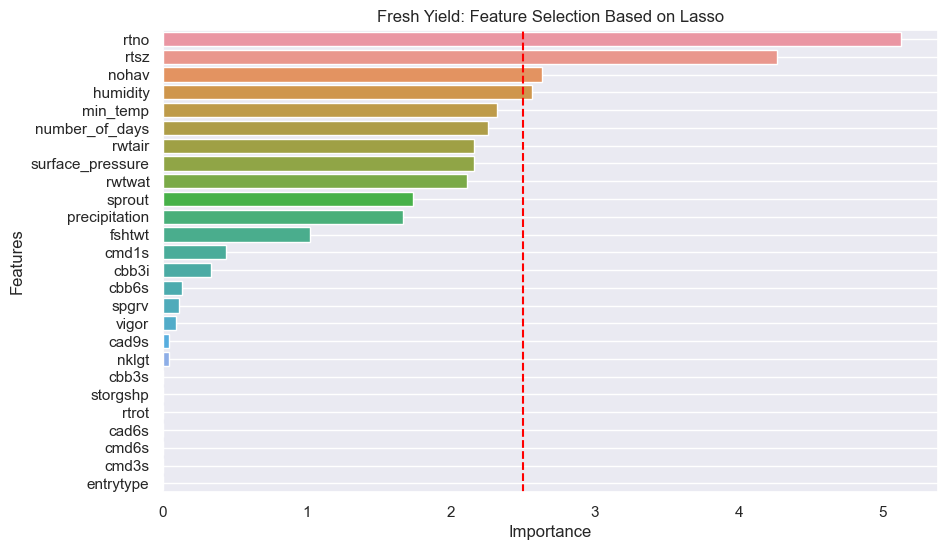

['nohav', 'rtno', 'rtsz', 'humidity']

In [109]:
fyld_selected_headers = feature_selection_process(
    x_train=yield_data["train"], 
    y_train=yield_data["y_train"], 
    x_test=yield_data["test"],
    y_test = yield_data["y_test"],
    title="Fresh Yield"
)

fyld_selected_headers

Test MSE - Lasso Regression: 29.540594584063534
Tuning parameter for Lasso Regression (lambda value): 0.026683496156031508
Lasso Score (R Squared: 0.3728491347933336


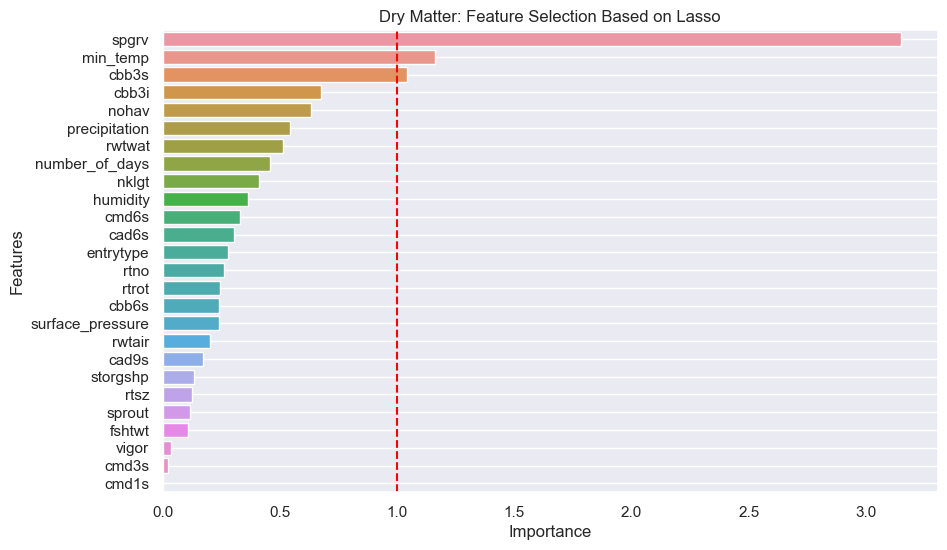

['cbb3s', 'spgrv', 'min_temp']

In [110]:
dm_selected_headers = feature_selection_process(
    x_train=dm_data["train"], 
    y_train=dm_data["y_train"], 
    x_test=dm_data["test"], 
    y_test = dm_data["y_test"],
    title = "Dry Matter"
)

dm_selected_headers

In [84]:
dm_features = features[dm_selected_headers]
dm_target = target['dm']

fyld_features = features[fyld_selected_headers]
fyld_target = target['fyld']

In [85]:
models = {
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10, 100],
            'fit_intercept': [True, False]
        }
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10, 100],
            'fit_intercept': [True, False]
        }
    },
    'Decision Tree Regressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 5, 10]
        }
    },
    'Random Forest Regressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 5, 10]
        }
    },
    'Gradient Boosting Regressor': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 5, 10]
        }
    },
    'xgb': {
        'model' : xgb.XGBRegressor(),
        'params': {
            'objective': ['reg:squarederror'],
            'eval_metric': ['rmse'],
            'eta': [0.01, 0.05, 0.1],
            'max_depth': [3, 6, 9],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    },
    'lgm' : {
        'model': lgb.LGBMRegressor(),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [31, 50, 100],
            'n_estimators': [50, 100, 200],
            'verbose': [0],
            'feature_fraction': [0.8, 1.0]
        }
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params':{
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    }
}

In [86]:
class MachineLearningModels:

    def __init__(self, features, target, models, grid=True):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            features, target, test_size=0.2, random_state=234
        )

        self.models = models
        self.grid = grid
        self.best_params = {}

    def fit_and_tune(self):
        for name, model in self.models.items():
            print("=" * 50)
            print(f"Fitting and tuning {name}")
            print("=" * 50)
            if self.grid:
                print("GridSearch")
                search = GridSearchCV(
                    model["model"],
                    model["params"],
                    cv=5,
                    scoring="neg_mean_squared_error",
                    random_state=234,
                    verbose=0,
                )
            else:
                print("Using RandomSearchCV")
                search = RandomizedSearchCV(
                    model["model"],
                    model["params"],
                    n_iter=5,
                    cv=5,
                    scoring="neg_mean_squared_error",
                    random_state=234,
                    verbose=0,
                )

            gr_search = search.fit(self.X_train, self.y_train)
            print("Best Parameters = {}".format(gr_search.best_params_))

            self.best_params[name] = gr_search.best_estimator_
            # self.best_params = gr_search.estimators_[0].best_params_
            # print(self.best_params)
            best_score = np.sqrt(-search.best_score_)
            print(f"Best parameters: {self.best_params}")
            print(f"Best score: {best_score}")

    def evaluate(self):
        model_results = []
        for name, model in self.models.items():
            print(f"Evaluating {name}...")

            y_pred = self.best_params[name].predict(self.X_test)
            metrics_data = {"actual_values":self.y_test, "predicted":y_pred}
            rmse_y1 = np.sqrt(np.mean((self.y_test - y_pred)**2))
            mae = np.mean(np.abs(self.y_test - y_pred))
            r2_y1 = r2_score(self.y_test, y_pred=y_pred)
            model_results.append({"name": name, "rmse": rmse_y1, "mae":mae, "r2_y1": r2_y1, "data": metrics_data})

        return model_results

In [87]:
fit_ml_models = MachineLearningModels(dm_features, dm_target, models, False)
fit_ml_models.fit_and_tune()
dm_rnd_model_results = fit_ml_models.evaluate()

Fitting and tuning Ridge Regression
Using RandomSearchCV
Best Parameters = {'fit_intercept': True, 'alpha': 0.01}
Best parameters: {'Ridge Regression': Ridge(alpha=0.01)}
Best score: 5.555795860402508
Fitting and tuning Lasso Regression
Using RandomSearchCV
Best Parameters = {'fit_intercept': True, 'alpha': 0.01}
Best parameters: {'Ridge Regression': Ridge(alpha=0.01), 'Lasso Regression': Lasso(alpha=0.01)}
Best score: 5.564256622987478
Fitting and tuning Decision Tree Regressor
Using RandomSearchCV
Best Parameters = {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
Best parameters: {'Ridge Regression': Ridge(alpha=0.01), 'Lasso Regression': Lasso(alpha=0.01), 'Decision Tree Regressor': DecisionTreeRegressor(max_depth=10, min_samples_leaf=2)}
Best score: 4.709652492104222
Fitting and tuning Random Forest Regressor
Using RandomSearchCV
Best Parameters = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10}
Best parameters: {'Ridge Regressi

In [91]:
fyld_fit_ml_models = MachineLearningModels(fyld_features, fyld_target, models, False)
fyld_fit_ml_models.fit_and_tune()
fyld_rnd_model_results = fyld_fit_ml_models.evaluate()

Fitting and tuning Ridge Regression
Using RandomSearchCV
Best Parameters = {'fit_intercept': True, 'alpha': 10}
Best parameters: {'Ridge Regression': Ridge(alpha=10)}
Best score: 10.074478151445376
Fitting and tuning Lasso Regression
Using RandomSearchCV
Best Parameters = {'fit_intercept': True, 'alpha': 0.01}
Best parameters: {'Ridge Regression': Ridge(alpha=10), 'Lasso Regression': Lasso(alpha=0.01)}
Best score: 10.074484749719511
Fitting and tuning Decision Tree Regressor
Using RandomSearchCV
Best Parameters = {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
Best parameters: {'Ridge Regression': Ridge(alpha=10), 'Lasso Regression': Lasso(alpha=0.01), 'Decision Tree Regressor': DecisionTreeRegressor(max_depth=10, min_samples_leaf=2)}
Best score: 8.481216703422858
Fitting and tuning Random Forest Regressor
Using RandomSearchCV
Best Parameters = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10}
Best parameters: {'Ridge Regression': R

In [179]:
%pip install scikeras
from scikeras.wrappers import KerasRegressor

Note: you may need to restart the kernel to use updated packages.


In [1]:
def nn_model2(data_features, data_target, target):
    
    X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.2, random_state=234)


    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    def make_regression_ann(initializer='uniform', activation='relu', learning_rate= 0.001, rate = 0.15):

        model = Sequential()
        model.add(Dense(units=64, input_dim=(X_train_scaled.shape[1]), kernel_initializer=initializer, activation=activation))
        model.add(Dense(units=64, kernel_initializer=initializer, activation=activation))
        model.add(Dropout(rate=rate))
        model.add(Dense(units=32, kernel_initializer=initializer, activation=activation))
        model.add(BatchNormalization())
        model.add(Dense(units=16, kernel_initializer=initializer, activation=activation))
        model.add(Dense(1, kernel_initializer=initializer))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate= learning_rate))

        return model

    param_grid = {
        'model__initializer': ['normal', 'uniform'],
        'model__activation': ['relu', 'sigmoid'],
        'batch_size': [16, 32, 64],
        'epochs': [50],
        "model__learning_rate": [0.001, 0.005, 0.01],
        "model__rate": [0, 0.15, 0.25]
    }

    random_search = RandomizedSearchCV(
        estimator=KerasRegressor(make_regression_ann, verbose=0),
        param_distributions=param_grid,
        cv=5
    )

    random_result = random_search.fit(X_train_scaled, y_train)

    model = Sequential()
    model.add(Dense(units=64, input_dim=(X_train_scaled.shape[1]), kernel_initializer=random_result.best_params_["model__initializer"], activation=random_result.best_params_["model__activation"]))
    model.add(Dense(units=64, kernel_initializer=random_result.best_params_["model__initializer"], activation=random_result.best_params_["model__activation"]))
    model.add(Dropout(rate=random_result.best_params_["model__rate"]))
    model.add(Dense(units=32, kernel_initializer=random_result.best_params_["model__initializer"], activation=random_result.best_params_["model__activation"]))
    model.add(BatchNormalization())
    model.add(Dense(units=16, kernel_initializer=random_result.best_params_["model__initializer"], activation=random_result.best_params_["model__activation"]))
    model.add(Dense(1, kernel_initializer=random_result.best_params_["model__initializer"]))
    model.compile(optimizer=Adam(learning_rate=random_result.best_params_["model__learning_rate"]), loss="mean_squared_error")
    
    model.fit(X_train_scaled, y_train, batch_size=random_result.best_params_["batch_size"], epochs=random_result.best_params_["epochs"])

    y_pred = model.predict(X_test_scaled)
    
    rmse_y1 = np.sqrt(np.mean((y_test - y_pred.flatten())**2))
    mae = np.mean(np.abs(y_test - y_pred.flatten()))
    r2_y1 = r2_score(y_test, y_pred=y_pred.flatten())

    nn = {"name": "Neural Network", "rmse": rmse_y1, "mae": mae, "r2_y1": r2_y1, "target": target}
    return nn

dm_nn_model = nn_model2(dm_features, dm_target, "DM")
fyld_nn_model = nn_model2(fyld_features, fyld_target, "FYLD")

print(dm_nn_model)
print(fyld_nn_model)


NameError: name 'dm_features' is not defined

In [272]:
model = Sequential()
model.add(Dense(units=64, input_dim=(X_train_scaled.shape[1]), kernel_initializer=random_result.best_params_["model__initializer"], activation=random_result.best_params_["model__activation"]))
model.add(Dense(units=64, kernel_initializer=random_result.best_params_["model__initializer"], activation=random_result.best_params_["model__activation"]))
model.add(Dense(units=32, kernel_initializer=random_result.best_params_["model__initializer"], activation=random_result.best_params_["model__activation"]))
model.add(Dense(units=16, kernel_initializer=random_result.best_params_["model__initializer"], activation=random_result.best_params_["model__activation"]))
model.add(Dense(1, kernel_initializer=random_result.best_params_["model__initializer"]))
model.compile(optimizer=Adam(learning_rate=random_result.best_params_["model__learning_rate"]), loss="mean_squared_error")
model.fit(X_train_scaled, y_train, batch_size=random_result.best_params_["batch_size"], epochs=random_result.best_params_["epochs"])

y_pred = model.predict(X_test_scaled)

rmse_y1 = np.sqrt(np.mean((y_test - y_pred.flatten())**2))
mae = np.mean(np.abs(y_test - y_pred.flatten()))
r2_y1 = r2_score(y_test, y_pred=y_pred.flatten())

Epoch 1/100
245/245 [==============================] - 2s 4ms/step - loss: 92.0919
Epoch 2/100
245/245 [==============================] - 1s 2ms/step - loss: 40.1592
Epoch 3/100
245/245 [==============================] - 1s 2ms/step - loss: 36.4086
Epoch 4/100
245/245 [==============================] - 1s 3ms/step - loss: 34.9127
Epoch 5/100
245/245 [==============================] - 1s 3ms/step - loss: 37.9324
Epoch 6/100
245/245 [==============================] - 1s 2ms/step - loss: 36.6494
Epoch 7/100
245/245 [==============================] - 1s 2ms/step - loss: 33.6480
Epoch 8/100
245/245 [==============================] - 1s 2ms/step - loss: 35.6651
Epoch 9/100
245/245 [==============================] - 1s 3ms/step - loss: 35.8034
Epoch 10/100
245/245 [==============================] - 1s 3ms/step - loss: 35.2721
Epoch 11/100
245/245 [==============================] - 1s 3ms/step - loss: 32.3055
Epoch 12/100
245/245 [==============================] - 1s 3ms/step - loss: 34.0482
E

In [273]:
r2_y1

0.45631877004198573

In [261]:

# def nn_model(data_features, data_target, target):
    
#     X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.2, random_state=234)

#     # Standardize the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Define the ANN model
#     model = Sequential()
#     model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
#     model.add(Dense(64, activation='relu'))
#     # model.add(BatchNormalization())
#     model.add(Dense(32, activation='relu'))
#     # model.add(BatchNormalization())
#     model.add(Dense(16, activation='relu'))
#     model.add(Dense(1, kernel_regularizer=l2(0.001)))
#     model.compile(optimizer=Adam(learning_rate=.005), loss='mean_squared_error')

#     # Train the model
#     model.fit(X_train_scaled, y_train, epochs=50, batch_size=12, validation_split=0.2)

#     # Predict on the test set
#     y_pred = model.predict(X_test_scaled)
#     y_pred = y_pred.flatten()
#     rmse_y1 = np.sqrt(np.mean((y_test - y_pred)**2))
#     mae = np.mean(np.abs(y_test - y_pred))
#     r2_y1 = r2_score(y_test, y_pred=y_pred)

#     nn = {"name": "Neural Network", "rmse": rmse_y1, "mae": mae, "r2_y1": r2_y1, "target": target}
#     return nn

# dm_nn_model = nn_model(dm_features, dm_target, "DM")
# fyld_nn_model = nn_model(fyld_features, fyld_target, "FYLD")

# print(dm_nn_model)
# print(fyld_nn_model)

In [174]:
rnd_model_frame = pd.DataFrame(dm_rnd_model_results)
fyld_model_frame = pd.DataFrame(fyld_rnd_model_results)
dm_model_frame_metrics = rnd_model_frame[["name","rmse","mae","r2_y1"]]
fyld_model_frame_metrics = fyld_model_frame[["name","rmse","mae","r2_y1"]]
dm_model_frame_metrics["target"] = "DM"
fyld_model_frame_metrics["target"] = "FYLD"

dm_model_frame_metrics = pd.concat([dm_model_frame_metrics, pd.DataFrame([dm_nn_model])], ignore_index=True)
fyld_model_frame_metrics = pd.concat([fyld_model_frame_metrics, pd.DataFrame([fyld_nn_model])], ignore_index=True)

dm_model_frame_metrics = dm_model_frame_metrics.sort_values(ascending=False, by=['rmse']).reset_index(drop=True)
fyld_model_frame_metrics = fyld_model_frame_metrics.sort_values(ascending=False, by=['rmse']).reset_index(drop=True)

dm_model_frame_metrics

,name,rmse,mae,r2_y1,target
0,Support Vector Regressor,5.628393,4.562221,0.377007,DM
1,Lasso Regression,5.585437,4.507504,0.386480,DM
2,Ridge Regression,5.568561,4.470596,0.390182,DM
3,Neural Network,5.380771,4.158491,0.430618,DM
4,Decision Tree Regressor,4.731106,3.551111,0.559810,DM
5,xgb,4.656245,3.551554,0.573630,DM
6,Random Forest Regressor,4.649355,3.517067,0.574891,DM
7,Gradient Boosting Regressor,4.574737,3.439228,0.588427,DM
8,lgm,4.562983,3.479098,0.590539,DM


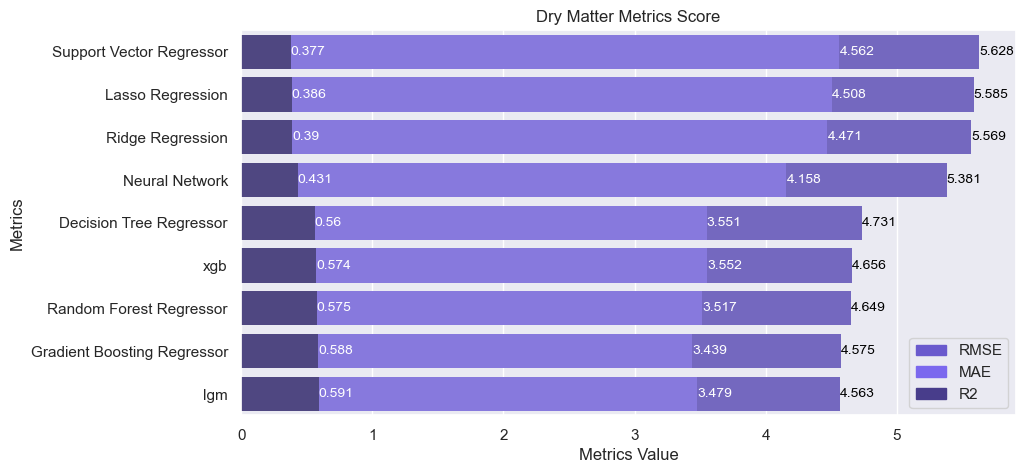

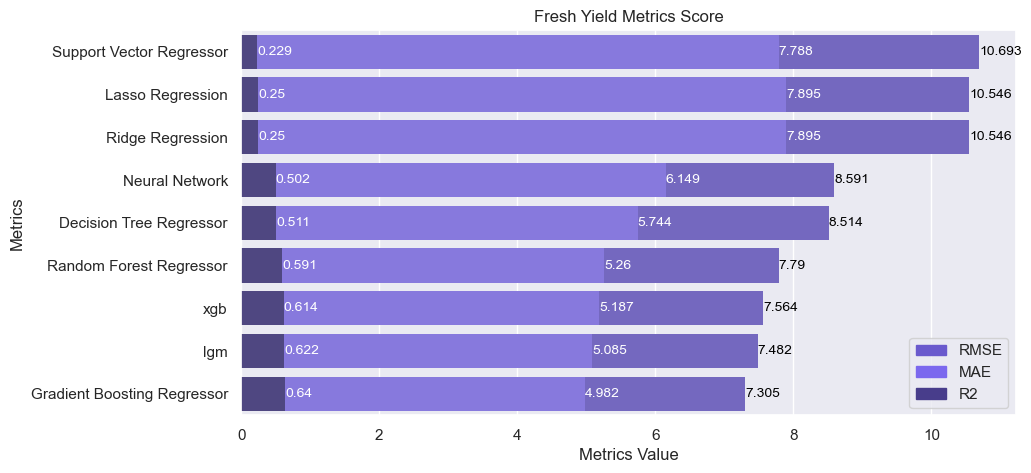

In [175]:

def plot_metrics(data, title):
    data = round(data, 3)
    plt.figure(figsize=(10,5))
    sns.set_style("darkgrid")

    ax = sns.barplot(data, x="rmse", y = "name", orient="h", color="slateblue", linewidth=0)
    ax.bar_label(ax.containers[0], fontsize=10, color="black")
    ax2 = sns.barplot(data, x="mae", y="name", orient="h",  color='mediumslateblue', linewidth=0)
    ax2.bar_label(ax2.containers[1], fontsize=10, color="white")
    ax3 = sns.barplot(data, x="r2_y1", y="name", orient="h",  color='darkslateblue', linewidth=0)
    ax3.bar_label(ax3.containers[2], fontsize=10, color= "white")

    top_bar = mpatches.Patch(color='slateblue', label='RMSE')
    middle_bar = mpatches.Patch(color='mediumslateblue', label='MAE')
    bottom_bar = mpatches.Patch(color='darkslateblue', label='R2')

    plt.title(title)
    plt.xlabel("Metrics Value")
    plt.ylabel("Metrics")
    plt.legend(handles=[top_bar, middle_bar, bottom_bar])
    plt.show()
    
plot_metrics(dm_model_frame_metrics, "Dry Matter Metrics Score")
plot_metrics(fyld_model_frame_metrics, "Fresh Yield Metrics Score")

0.5905394023360702


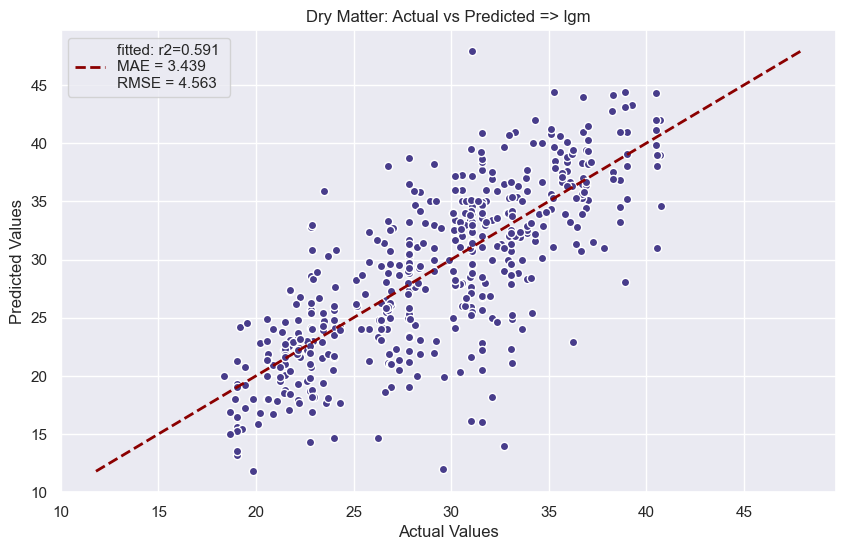

0.6400632630499856


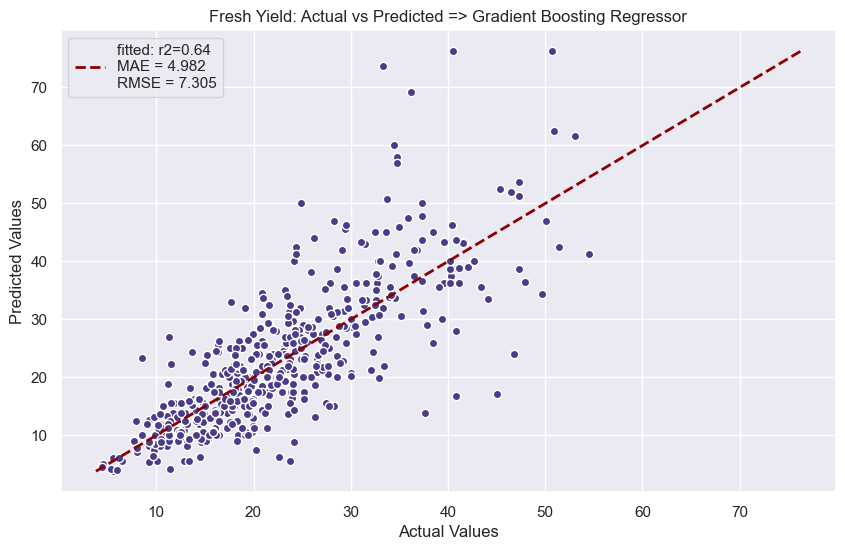

In [118]:
def plot_performance(model_results, data, title):
    x = [res["data"] for res in model_results if res["r2_y1"] == max(data["r2_y1"])][0]
    x = pd.DataFrame(x)
    model_name = [res["name"] for res in model_results if res["r2_y1"] == max(data["r2_y1"])][0]

    r2val = max(data["r2_y1"])
    maeval = min(data["mae"])
    rmseval = min(data["rmse"])
    print(r2val)
    residuals = np.array(x["actual_values"]) - np.array(x["predicted"])
    y_pred = x["predicted"]
    y_true = x["actual_values"]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(y = y_true, x = y_pred, color="darkslateblue", marker="o", linewidth=1)
    plt.plot(
        [min(y_true), max(y_true)],
        [min(y_true), max(y_true)],
        color="darkred",
        linestyle="--",
        linewidth=2,
        label= f"fitted: r2={round(r2val, 3)} \nMAE = {round(maeval,3)} \nRMSE = {round(rmseval, 3)}"
    )
    plt.title(f"{title}: Actual vs Predicted => {model_name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid(True)
    plt.legend()
    plt.show()
    

plot_performance(dm_rnd_model_results, dm_model_frame_metrics, title="Dry Matter")
plot_performance(fyld_rnd_model_results, fyld_model_frame_metrics, title="Fresh Yield")


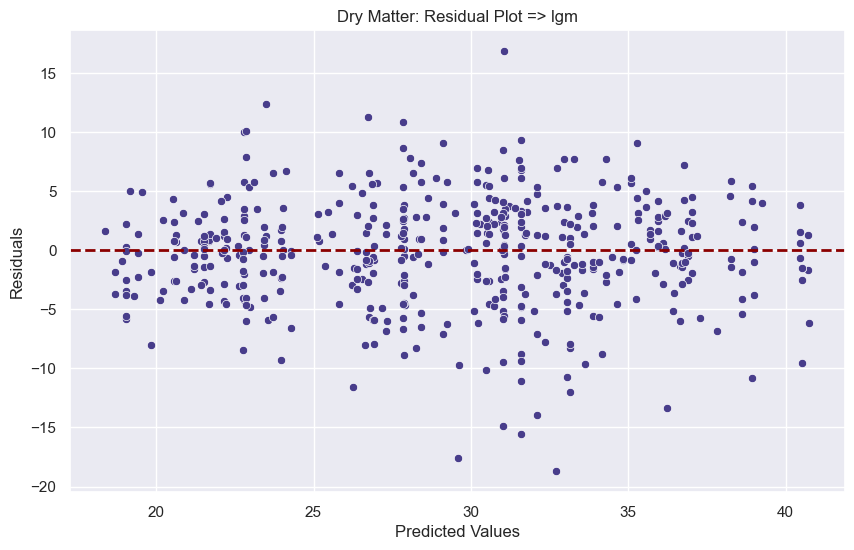

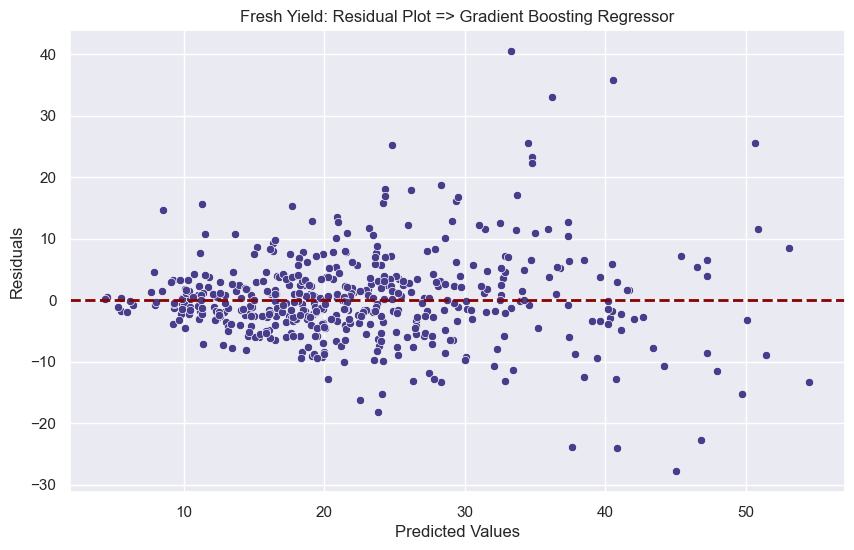

In [119]:
def plot_residuals(model_results, data, title):
    plt.figure(figsize=(10, 6))
    x = [res["data"] for res in model_results if res["r2_y1"] == max(data["r2_y1"])][0]
    x = pd.DataFrame(x)
    model_name = [res["name"] for res in model_results if res["r2_y1"] == max(data["r2_y1"])][0]


    residuals = np.array(x["actual_values"]) - np.array(x["predicted"])
    y_pred = x["predicted"]

    ax = sns.scatterplot(x=y_pred, y=residuals, color='darkslateblue', marker='o')
    ax.axhline(y=0, color='darkred', linestyle='--', linewidth=2)
    plt.title(f"{title}: Residual Plot => {model_name}")
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()
    
plot_residuals(dm_rnd_model_results, dm_model_frame_metrics, "Dry Matter")
plot_residuals(fyld_rnd_model_results, fyld_model_frame_metrics, "Fresh Yield")